# Часть 2 / 3

разведочного анализа данных по данным международного сервиса по продаже и аренде жилой недвижимости Alyona Ivanovna Real Estate Agency / AI REA Ltd. 

Задача данной Части - закоммитить результаты очистки данных от пропусков.

Для проведения анализа получены данные: файл _data.csv.

In [566]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelEncoder
import re
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS 
import matplotlib.pyplot as plt
import seaborn as sns

In [567]:
# вспомогательная функция для оценки типов данных в столбце по первой строке
def column_type(test : pd.DataFrame):
    answer = pd.DataFrame([], columns=['Columns', 'Type'])
    for i in test.columns.to_list():
        answer.loc[len(answer)] =  [i, type(test[i][0])]
        answer.reset_index(drop=True)
    return answer

## Загрузка данных

In [568]:
path = '/home/andrey/Documents/Working/W3D4-real/data/_data.csv'
data = pd.read_csv(path)
data.reset_index()
data.head(3)

,Unnamed: 0,ID объявления,Количество комнат,Тип,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,...,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление
0,0,271271157,4,Квартира,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",...,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157
1,1,271634126,4,Квартира,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",...,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126
2,2,271173086,"4, Оба варианта",Квартира,м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",...,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086


Посмотрим на первую запись предоставленного массива данных:

In [569]:
data.loc[0, :]

Unnamed: 0                                                                  0
ID  объявления                                                      271271157
Количество комнат                                                           4
Тип                                                                  Квартира
Метро                                            м. Смоленская (9 мин пешком)
Адрес                                           Москва, улица Новый Арбат, 27
Площадь, м2                                                        200.0/20.0
Дом                                                          5/16, Монолитный
Парковка                                                            подземная
Цена                        500000.0 руб./ За месяц, Залог - 500000 руб., ...
Телефоны                                                         +79166369231
Описание                    Без комиссии для нанимателя! Бонус коллегам 12...
Ремонт                                                          

#Поиск категориальных данных (по визуальному анализу практически все даные категориальные):

In [570]:
def find_categories(data):
    answer = []   
    a2 = ['', '', '']
    for name in data.columns:       
        a2[0] = name
        if (type(data[name][0]) == str):
            a2[1] = 'строка'
        a2[2] = str(data[name].nunique())
        # if (data[name].nunique() <= 3):
        #     a2[2] = 'мало'
        # else: 
        #     a2[2] = 'много'
        answer.append(a2.copy())
        #if (s!=name): print(s)
    return print(pd.DataFrame(answer, columns=['Столбец', 'Тип', 'Уникальных']))

find_categories(data)

                     Столбец     Тип Уникальных
0                 Unnamed: 0              23368
1             ID  объявления              23368
2          Количество комнат  строка         24
3                        Тип  строка          1
4                      Метро  строка       5866
5                      Адрес  строка      12850
6                Площадь, м2  строка      11255
7                        Дом  строка       2565
8                   Парковка  строка          5
9                       Цена  строка       3922
10                  Телефоны  строка      13172
11                  Описание  строка      23078
12                    Ремонт  строка          4
13        Площадь комнат, м2  строка       3990
14                    Балкон  строка         18
15                      Окна  строка          3
16                   Санузел  строка         20
17  Можно с детьми/животными  строка          3
18             Дополнительно  строка        528
19               Название ЖК  строка    

Практически все столбцы - строки. Для обработки методами машинного обучения необходимо преобразовать в цифровое описание.

Посмотрим на пропущенные значения.

In [571]:
data.shape
data_length = data.shape[0]
pd.DataFrame({'Число пропущенных' : data.isnull().sum(), 
              'Доля из записей, %' : round(data.isnull().sum()/data_length*100, ndigits=1)})

,Число пропущенных,"Доля из записей, %"
Unnamed: 0,0,0.0
ID объявления,0,0.0
Количество комнат,1041,4.5
Тип,0,0.0
Метро,1315,5.6
Адрес,0,0.0
"Площадь, м2",0,0.0
Дом,0,0.0
Парковка,13417,57.4
Цена,0,0.0


Число пропущенных значений впечатляет! Делать описание статистики по каждому столбцу на данном этапе бессмысленно - все в категориях. Посмотрим сколько останется записей, если удалить все строки с пропущенными занчениями.

In [572]:
round(len(data.dropna(axis = 0))/len(data)*100, ndigits=2)
#df = df.dropna(axis = 0)

0.03

Остается <1% от первоначальных записей! Это не сработает, ищем вариант заполнения пропущенных значений данными.

In [573]:
# сразу удалим ячейки, не имеющие смысла при анализе
data = data.drop('Unnamed: 0', axis=1) 
data = data.drop('ID  объявления', axis=1) 
data = data.drop('Телефоны', axis=1) 
data = data.drop('Описание', axis=1)
data = data.drop('Ссылка на объявление', axis=1) 


## Обработка адреса расположения квартиры

In [574]:
pd.DataFrame(data['Адрес'].apply(lambda x: x.split(', ')[0]).value_counts())

,count
Адрес,
Москва,19737
Санкт-Петербург,3028
Краснодарский край,603


In [575]:
a14 =  data.drop(data.loc[data['Адрес'].apply(lambda x: x.split(', ')[0] != 'Москва')].index, inplace=True)
a14

In [576]:
data['Адрес'].head()

0       Москва, улица Новый Арбат, 27
1       Москва, улица Новый Арбат, 27
2       Москва, улица Новый Арбат, 27
3    Москва, переулок Плотников, 21С1
4       Москва, улица Новый Арбат, 15
Name: Адрес, dtype: object

In [577]:
len(data) #23368

19737

In [578]:
# разбиваем строчку с адресом на составляющие
c1 =  data['Адрес'].str.split(', ', expand=True)
#data[['city', 'street', 'house', '11', '12']] = c1[[0, 1, 2]]
set(c1[0])
# в массиве данные о квартирах из нескольких городов
# по правилам берем только квартиры из Москвы

{'Москва'}

In [579]:
# удаляем квартиры не из Москвы
data = data[data['Адрес'].str.contains('Москва')]
data = data.reset_index(drop=True)
len(data) #19737

19737

In [580]:
# разбиваем строчку еще раз
c1 =  data['Адрес'].str.split(', ', expand=True)
c1.head()

,0,1,2,3,4,5,6
0,Москва,улица Новый Арбат,27,None,None,None,None
1,Москва,улица Новый Арбат,27,None,None,None,None
2,Москва,улица Новый Арбат,27,None,None,None,None
3,Москва,переулок Плотников,21С1,None,None,None,None
4,Москва,улица Новый Арбат,15,None,None,None,None


In [581]:
c1.tail()
# проблема в том, что название улицы и номер дома сдвигается - ловим

,0,1,2,3,4,5,6
19732,Москва,Боровское шоссе,2к7,ш. Боровское (3 км до МКАД),ш. Сколковское (8 км до МКАД),None,None
19733,Москва,Производственная улица,8к1,ш. Боровское (5 км до МКАД),ш. Киевское (7 км до МКАД),None,None
19734,Москва,Боровский проезд,11,None,None,None,None
19735,Москва,улица Богданова,6к1,ш. Боровское (3 км до МКАД),ш. Сколковское (8 км до МКАД),None,None
19736,Москва,улица Богданова,2к1,ш. Боровское (3 км до МКАД),ш. Киевское (8 км до МКАД),None,None


In [582]:
# определяем типы улиц - к ним привяжемся чтобы вытащить адрес
a1_1 = set()
pattern = re.compile("[0-9#№]")
c1 =  data['Адрес'].str.split(', ', expand=True)
a1 = set()

for j in range(1, 7):
    c2_2 = c1.loc[:, j].str.split(' ', expand=True)
    #a1 = set(c2_2.loc[0, :]) # первая строка
    for i in range(0, len(c2_2)): #вторые строки
        a1.update(set(c2_2.loc[i, :]))
    # set готов

a1_list = list(a1)
a1_1 = list()
# i=2
for i in range(0, len(a1_list)):
        if not pattern.match(str(a1_list[i])[0]):
            if str(a1_list[i]).islower():
                if not any(x in a1_list[i] for x in '1234567890'):
                    a1_1.append(str(a1_list[i]))

len(a1_1)
a1_1 = list(set(a1_1))



In [583]:
# перечень всех слов, похожих на назщвание адреса
a1_1

['переулок',
 'рощи',
 'улица',
 'ао',
 'аллея',
 'тер.',
 'мкр',
 'проезд',
 'проспект',
 'центра',
 'кв-л',
 'линия',
 'года',
 'бульвар',
 'шоссе',
 'набережная',
 'тупик',
 'лет',
 'площадь',
 'пос.',
 'и',
 'деревня',
 'до',
 'км',
 'ш.',
 'инновационного',
 'р-н',
 'зона']

In [584]:
# укорачиваем до реального списка
pattern_streets = ['бульвар', 'тупик', 'линия', 'проезд', 'аллея', 'улица', 
                   'лет', 'переулок', 'шоссе', 'кв-л', 'площадь', 'проспект',
                     'набережная']
# остальные - пустышки

In [585]:
# сейчас нужны только строки
for i  in range(1, 7):
    c1[i] = c1[i].astype(str)
# находим все что в списке и помечаем номер столбца
c1['x1'] = ''
for i in range(0, len(c1)):
    for j in range(1, 7):
        if any(x in c1.loc[i, j] for x in pattern_streets):
            c1.loc[i, 'x1'] = c1.loc[i, 'x1'] + str(j)
c1.head()
# x1 - столбец с номер где нашли адрес

,0,1,2,3,4,5,6,x1
0,Москва,улица Новый Арбат,27,None,None,None,None,1
1,Москва,улица Новый Арбат,27,None,None,None,None,1
2,Москва,улица Новый Арбат,27,None,None,None,None,1
3,Москва,переулок Плотников,21С1,None,None,None,None,1
4,Москва,улица Новый Арбат,15,None,None,None,None,1


In [586]:
# смотрим сколько нашлось столбцов с адресом
c1['x1_len'] = c1['x1'].str.len()
c1['x1_len'].describe()
# максимум =1 - супер, только один столбец

count    19737.000000
mean         0.989512
std          0.101875
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: x1_len, dtype: float64

In [587]:
c1_04 = c1[c1['x1_len']==0]
len(c1_04) #207
# при этом 207 строк с плохим адресом

207

In [588]:
# переносим в отдельные столбцы
c1['street'] = ''
c1['house'] = ''

for i in range(0, len(c1)):
    if c1.loc[i, 'x1_len'] != 0:
        c1.loc[i, 'street'] = c1.loc[i, int(c1.loc[i, 'x1'])]
        c1.loc[i, 'house'] = c1.loc[i, int(c1.loc[i, 'x1'])+1]

c1.head()

,0,1,2,3,4,5,6,x1,x1_len,street,house
0,Москва,улица Новый Арбат,27,None,None,None,None,1,1,улица Новый Арбат,27
1,Москва,улица Новый Арбат,27,None,None,None,None,1,1,улица Новый Арбат,27
2,Москва,улица Новый Арбат,27,None,None,None,None,1,1,улица Новый Арбат,27
3,Москва,переулок Плотников,21С1,None,None,None,None,1,1,переулок Плотников,21С1
4,Москва,улица Новый Арбат,15,None,None,None,None,1,1,улица Новый Арбат,15


In [589]:
# переносим в основной массив
data['street'] = c1['street']
data['house'] = c1['house']
data[['Адрес', 'street','house']].head()
# вроде получилось

,Адрес,street,house
0,"Москва, улица Новый Арбат, 27",улица Новый Арбат,27
1,"Москва, улица Новый Арбат, 27",улица Новый Арбат,27
2,"Москва, улица Новый Арбат, 27",улица Новый Арбат,27
3,"Москва, переулок Плотников, 21С1",переулок Плотников,21С1
4,"Москва, улица Новый Арбат, 15",улица Новый Арбат,15


In [590]:
len(data[data['street']=='']) #207

207

In [591]:
data = data.drop('Адрес', axis=1) # удаляем столбец с адресом
data = data.loc[data['street'] !='', :] 
data = data.reset_index(drop=True)
len(data)

19530

In [592]:
# кодируем Улицу
le01 = LabelEncoder()
le01.fit(data['street'])
data['street'] = le01.transform(data['street'])

In [593]:
# кодируем Номер дома
le01 = LabelEncoder()
le01.fit(data['house'])
data['house'] = le01.transform(data['house'])

In [594]:
data[['street', 'house']].head()

,street,house
0,1579,877
1,1579,877
2,1579,877
3,1180,729
4,1579,400


## Стоимость аренды

In [595]:
# заглянем сколько строк
len(data) # 19737 records

19530

In [596]:
# число уникальных
len(set(data['Цена'])) # 2219 - не удивительно

2202

In [597]:
# пустышек: 
len(data[data['Цена'].isna()]) # 0 - не удивительно

0

In [598]:
data.loc[1:20, 'Цена'].head()

1    500000.0 руб./ За месяц, Залог - 500000 руб., ...
2    500000.0 руб./ За месяц, Залог - 500000 руб., ...
3    400000.0 руб./ За месяц, Залог - 400000 руб., ...
4    225000.0 руб./ За месяц, Залог - 225000 руб., ...
5    470000.0 руб./ За месяц, Залог - 470000 руб., ...
Name: Цена, dtype: object

In [599]:
# разделим столбец на составляющие - а их много
c4 =  data.loc[: ,'Цена'].str.split(', ', expand=True)
c4.head(2)

,0,1,2,3,4,5
0,500000.0 руб./ За месяц,Залог - 500000 руб.,Коммунальные услуги включены,Срок аренды - Длительный,Предоплата 1 мес,None
1,500000.0 руб./ За месяц,Залог - 500000 руб.,Коммунальные услуги включены,Срок аренды - Длительный,Предоплата 1 мес,None


In [600]:
# ожидаемый состав столбцов из одного столбца Цена:
#0 - цена за месяц price
#1 - сумма коммуналки utilities.cost
#2 - сумма залога deposit
#3 - коммунальные услуги включены utilities.included
#4 - срок аренды rent.length
#5 - предоплата price.advance

In [601]:
# посмотрим на строчку с максимальным заполнением
c4.loc[c4[5].notna(), :].head(2)

,0,1,2,3,4,5
1178,36000.0 руб./ За месяц,Сумма коммунальных платежей - 2000.0 руб.,Залог - 36000 руб.,Коммунальные услуги включены,Срок аренды - Длительный,Предоплата 1 мес
2135,140000.0 руб./ За месяц,Сумма коммунальных платежей - 13000.0 руб.,Залог - 125000 руб.,Коммунальные услуги включены,Срок аренды - Длительный,Предоплата 1 мес


In [602]:
# готовим новые столбцы
data['price'] = '0'
data['utilities_cost'] = '0'
data['deposit'] = '0'
data['utilities_included'] = '0' #предположу что лишнее - оставим на конец
data['rent_length'] = '0'
data['price_advance'] = '0'
# data['flag'] = '0'

In [603]:
# в столбце цены обнаружились не только рубли:
# 23 такие записи:
# 356      5000.0 $/ За месяц, Залог - 5409 $, Коммунальн...
# 443      5000.0 $/ За месяц, Залог - 5000 $, Срок аренд...
# 444      5000.0 $/ За месяц, Залог - 5000 $, Коммунальн...
# 10101    5000.0 $/ За месяц, Залог - 5000 $, Коммунальн...
# 11539    10000.0 $/ За месяц, Залог - 10000 $, Коммунал...
# 11540    10000.0 $/ За месяц, Залог - 10000 $, Срок аре...
# 12054    9800.0 €/ За месяц, Залог - 9800 €, Коммунальн...

# так как есть разные курсы - делаем котировки
rate_USD = 100
rate_EUR = 105

In [604]:
column_type(c4)

,Columns,Type
0,0,<class 'str'>
1,1,<class 'str'>
2,2,<class 'str'>
3,3,<class 'str'>
4,4,<class 'str'>
5,5,<class 'NoneType'>


In [605]:

#a_price =  
for i in range(0,len(c4)):
    a_price =  float(re.findall(r'\d+', c4.loc[i, 0])[0])

In [606]:
# разносим полученные столбцы в несколько в нашем массиве

for i in range(0,len(data)):
    # цена за месяц
    a_price =  float(re.findall(r'\d+', c4.loc[i, 0])[0])
    if c4.loc[i, 0].find('€') != -1: # то цена не в евро
        data.loc[i, 'price'] = str(a_price*rate_EUR)  # должна быть цена в рублях
    else:
        if c4.loc[i, 0].find('$') != -1: # то цена не в долларах
            data.loc[i, 'price'] = str(a_price*rate_USD) 
        else: # тогда цена в рублях
            data.loc[i, 'price'] = str(a_price)


    for j in range(1, 5): # идем по оставшимся столбцам
        # ищем сумму по коммунальным платежам
        if c4.loc[i, j] is not None:
            if re.match(r'^Сумма [а-яА-Я0-9.,?() -]+руб.$', c4.loc[i, j]): 
                data.loc[i, 'utilities_cost'] = re.findall(r'\d+', c4.loc[i, j])[0] 

            # ищем залог 'Залог - 500000 руб.'
            if re.match(r'^Залог[а-яА-Я0-9.,?() ]+', c4.loc[i, j]): 
                a_deposit = float(re.findall(r'\d+', c4.loc[i, j])[0])
                if c4.loc[i, j].find('€') != -1: # то цена не в евро
                    data.loc[i, 'deposit'] = str(a_deposit*rate_EUR)  # должна быть цена в рублях
                else:
                    if c4.loc[i, j].find('$') != -1: # то цена не в долларах
                        data.loc[i, 'deposit'] = str(a_deposit*rate_USD) 
                    else: # тогда цена в рублях
                        data.loc[i, 'deposit'] = str(a_deposit)
                # if not re.match(r'^[а-яА-Я0-9.,?() -]* руб.$', c4.loc[i, j]): 
                #     data.loc[i, 'flag'] = data.loc[i, 'flag'] + '1'

            # ищем Коммунальные услуги
            if re.match(r'Коммунальные услуги включены$', c4.loc[i, j]): 
                data.loc[i, 'utilities_included'] = c4.loc[i, j].split(' ')[-1]

            # ищем Срок аренды 
            if re.match(r'^Срок аренды [а-яА-Я0-9.,?() -]+', c4.loc[i, j]): 
                a_length = c4.loc[i, j].split(' ')[-1]
                if a_length == 'месяцев':
                    data.loc[i, 'rent_length'] =  c4.loc[i, j].split(' ')[-2] + a_length
                else:
                    data.loc[i, 'rent_length'] =  a_length

            # ищем Предоплата
            if re.match(r'^Предоплата [а-яА-Я0-9.,?() -]+$', c4.loc[i, j]): 
                data.loc[i, 'price_advance'] = re.findall(r'\d+', c4.loc[i, j])[0] 



In [607]:
# смотрим на то что получилось
a11 = data.loc[:, ['Цена', 'price', 'utilities_cost', 'deposit', 'utilities_included', 'rent_length', 'price_advance']]
a11.head()

,Цена,price,utilities_cost,deposit,utilities_included,rent_length,price_advance
0,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",500000.0,0,500000.0,включены,Длительный,1
1,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",500000.0,0,500000.0,включены,Длительный,1
2,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",500000.0,0,500000.0,0,Длительный,1
3,"400000.0 руб./ За месяц, Залог - 400000 руб., ...",400000.0,0,400000.0,0,Длительный,1
4,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",225000.0,0,225000.0,включены,Длительный,1


In [608]:
# единичная запись - вроде все ок
a11.iloc[0, :]

Цена                  500000.0 руб./ За месяц, Залог - 500000 руб., ...
price                                                          500000.0
utilities_cost                                                        0
deposit                                                        500000.0
utilities_included                                             включены
rent_length                                                  Длительный
price_advance                                                         1
Name: 0, dtype: object

In [609]:
# обработка rent.length {'несколькомесяцев', 'Длительный'}
set(data['rent_length'])
data.loc[data['rent_length'] == 'несколькомесяцев', 'rent_length'] = '3'
data.loc[data['rent_length'] == 'Длительный', 'rent_length'] = '12'

In [610]:
# обработка price.advance {'11', '12', '3', '0', '1', '2', '6'}
set(data['price_advance'])
# предположу что без авансового платежа никто не заселит
data.loc[data['price_advance'] == '0', 'price_advance'] = '1'

In [611]:
# обработка подготовленных столбцов
data['price'] = data['price'].astype(float)
data['utilities_cost'] = data['utilities_cost'].astype(float)
data['deposit'] = data['deposit'].astype(float)
data['rent_length'] = data['rent_length'].astype(float)
data['price_advance'] = data['price_advance'].astype(float)

In [612]:
# кодируем utilities.included
le01 = LabelEncoder()
le01.fit(data['utilities_included'])
data['utilities_included'] = le01.transform(data['utilities_included'])
dict(zip(le01.classes_, range(len(le01.classes_)))) # а вот и словарь
# {'0': 0, 'включены': 1}

{'0': 0, 'включены': 1}

In [613]:
data = data.drop('Цена', axis=1) # удаляем ненужные столбцы

## Площадь квартиры

In [614]:
# смотрим на длину
len(data) # 19737 records

19530

In [615]:
# число уникальных записей
len(set(data['Площадь, м2'])) #

9519

In [616]:
# уникальные записи
#set(data['Площадь, м2'])
# {'42.5/19.0/10.0',
#  '38.0/19.1/8.3',
#  '32.5/18.3/6.0',
#  '55.0/32.0/12.0',

In [617]:
# число NaN записей
len(data[data['Площадь, м2'].isna()]) # 0 - cool

0

In [618]:
# выглядит как:
# 1      198.0/95.0/18.0
# 2      200.0/116.0/4.0
# 3      170.0/95.0/17.0
# 4        58.0/38.0/5.0
# 5                 92.0

# расшифровываем как:
# Общая площадь 198 м²
# Жилая площадь 95 м²
# Площадь кухни 18 м²

In [619]:
# собираем вспомогательный массив
a = data.loc[:, 'Площадь, м2'].str.count('/') # считаем разделители
# делим строку с площадями на максимум три столбца
b =  data.loc[: ,'Площадь, м2'].str.split('/', expand=True)
b[3] = a # собираем вместе
b.head()
# пока не очевидно что является второй цифрой, когда их всего 2

,0,1,2,3
0,200.0,20.0,None,1
1,198.0,95.0,18.0,2
2,200.0,116.0,4.0,2
3,170.0,95.0,17.0,2
4,58.0,38.0,5.0,2


In [620]:
# ожидаемый состав столбцов:
#0 - total.m2 - Общая площадь, м2 
#1 - live.m2 - Жилая площадь, м2
#2(1) - kitchen.m2 - Площадь кухни, м2

In [621]:
b[0] = b[0].astype(float)
b[1] = b[1].astype(float)
b[2] = b[2].astype(float)

In [622]:
b.head()

,0,1,2,3
0,200.0,20.0,NaN,1
1,198.0,95.0,18.0,2
2,200.0,116.0,4.0,2
3,170.0,95.0,17.0,2
4,58.0,38.0,5.0,2


In [623]:
# как оказалось при дальнейшем анализе, 
# вторая цифра строки Площади из массива
# это либо жилая площадь, либо площадь кухни
# и какая из них какая, не очень ясно

# посмотрим на размер кухни, когда все три значения заполнены
b_kitch = b[b[3] == 2]
b_kitch.loc[:, 'kitch_ave'] = b_kitch.loc[:, 2] /  b_kitch.loc[:, 0]
#b_kitch.head()
b_kitch.describe()

# предположим, что при значении второй цифры больше 22.2% 
# это уже не кухня, а жилай зона

/tmp/ipykernel_177212/2880602556.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_kitch.loc[:, 'kitch_ave'] = b_kitch.loc[:, 2] /  b_kitch.loc[:, 0]


,0,1,2,3,kitch_ave
count,15172.000000,15172.000000,15172.000000,15172.0,15172.000000
mean,59.946392,35.766900,9.867473,2.0,0.183578
std,41.318993,26.479526,4.860423,0.0,0.066308
min,10.000000,5.000000,1.000000,2.0,0.016071
25%,38.200000,20.000000,7.000000,2.0,0.136364
50%,47.000000,30.000000,9.000000,2.0,0.175439
75%,65.000000,40.000000,10.500000,2.0,0.222222
max,811.000000,490.000000,98.000000,2.0,0.757576


In [624]:
# новые столбцы в массиве
data['total_m2'] = 0
data['live_m2'] = 0
data['kitchen_m2'] = 0

In [625]:
# переносим из вспомогательного массива данные в основной:
for i in range(0, len(b)):
    if b.loc[i,3] == 0:    
        data.loc[i, 'total_m2'] = b.at[i, 0]
    else:
        if b.loc[i,3] == 1:
            data.loc[i, 'total_m2'] = b.at[i, 0]
            if b.at[i, 1]  > b.at[i, 0]*0.22:
                data.loc[i, 'live_m2'] = b.at[i, 1] 
            else:
                data.loc[i, 'kitchen_m2'] = b.at[i, 1] 
        else:
            data.loc[i, 'total_m2'] = b.at[i, 0]
            data.loc[i, 'live_m2'] = b.at[i, 1] 
            data.loc[i, 'kitchen_m2'] = b.at[i, 2] 

# смотрим что получилось
data[['total_m2', 'live_m2', 'kitchen_m2']].head()

/tmp/ipykernel_177212/494371415.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '222.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, 'total_m2'] = b.at[i, 0]
/tmp/ipykernel_177212/494371415.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, 'kitchen_m2'] = b.at[i, 1]
/tmp/ipykernel_177212/494371415.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '45.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, 'live_m2'] = b.at[i, 1]


,total_m2,live_m2,kitchen_m2
0,200.0,0.0,20.0
1,198.0,95.0,18.0
2,200.0,116.0,4.0
3,170.0,95.0,17.0
4,58.0,38.0,5.0


In [626]:
# теперь нужна цифра
# смотрим
column_type(data[['kitchen_m2', 'total_m2', 'live_m2']])

,Columns,Type
0,kitchen_m2,<class 'numpy.float64'>
1,total_m2,<class 'numpy.float64'>
2,live_m2,<class 'numpy.float64'>


In [627]:
# предположим мы удачно разделили кухню и жилую зону
# используем это для будущим моделей для закрытия NaN
data.loc[:, 'total_m2_x2'] = data['total_m2']**2
data[['total_m2', 'live_m2', 'kitchen_m2']].head()

,total_m2,live_m2,kitchen_m2
0,200.0,0.0,20.0
1,198.0,95.0,18.0
2,200.0,116.0,4.0
3,170.0,95.0,17.0
4,58.0,38.0,5.0


In [628]:
# отберем все ненулевые записи - живой вариант без студий
b2 = data[data['live_m2'] >0]
len(b2) #17312

16025

In [629]:
# оставим только значения для анализа
b2[['Площадь, м2', 'total_m2', 'live_m2', 'kitchen_m2']].head()

,"Площадь, м2",total_m2,live_m2,kitchen_m2
1,198.0/95.0/18.0,198.0,95.0,18.0
2,200.0/116.0/4.0,200.0,116.0,4.0
3,170.0/95.0/17.0,170.0,95.0,17.0
4,58.0/38.0/5.0,58.0,38.0,5.0
6,213.0/140.0/20.0,213.0,140.0,20.0


In [630]:
#а построим модель?
# площадь жилая
live01 = sm.add_constant(b2[['total_m2', 'total_m2_x2']])
model_live01 = OLS(b2['live_m2'], live01, hasconst=True).fit()

print(model_live01.summary())
# R2 = 0.891
# здесь неплохо

                            OLS Regression Results                            
Dep. Variable:                live_m2   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                 6.538e+04
Date:                Sun, 29 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:32:49   Log-Likelihood:                -58490.
No. Observations:               16025   AIC:                         1.170e+05
Df Residuals:                   16022   BIC:                         1.170e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.1274      0.174    -23.721      

In [631]:
# коэффиуиент const - смотрим
live_m2_const = model_live01.params
live_m2_const.iloc[0]

-4.127387866602192

In [632]:
# используем модель для пустых значений
# используем копию массива и полученную модель
#b3['live_m22'] = 0
for i in range(0, len(data)):
    if data.loc[i, 'live_m2'] == 0:
        data.loc[i, 'live_m2'] = int(model_live01.predict([live_m2_const.iloc[0], data.loc[i, 'total_m2'], data.loc[i, 'total_m2_x2']])[0])
data[['Площадь, м2', 'total_m2', 'live_m2', 'kitchen_m2']].head()
# позитивно

,"Площадь, м2",total_m2,live_m2,kitchen_m2
0,200.0/20.0,200.0,145.0,20.0
1,198.0/95.0/18.0,198.0,95.0,18.0
2,200.0/116.0/4.0,200.0,116.0,4.0
3,170.0/95.0/17.0,170.0,95.0,17.0
4,58.0/38.0/5.0,58.0,38.0,5.0


In [633]:
# готовимся к анализу площади кухни
data.loc[:, 'live_m2_x2'] = data['live_m2']**2
b2 = data[data['kitchen_m2'] != 0]

# теперь площадь кухни
kitchen01 = sm.add_constant(b2[['total_m2', 'total_m2_x2', 'live_m2', 'live_m2_x2']])
model_kitchen01 = OLS(b2['kitchen_m2'], kitchen01, hasconst=True).fit()
#results_kitchen01 = model_kitchen01.fit()
print(model_kitchen01.summary())
# R2 = 0.486 
# очень плохо, но лучше нет

                            OLS Regression Results                            
Dep. Variable:             kitchen_m2   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     3841.
Date:                Sun, 29 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:32:52   Log-Likelihood:                -43700.
No. Observations:               16275   AIC:                         8.741e+04
Df Residuals:                   16270   BIC:                         8.745e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.9754      0.068     58.685      

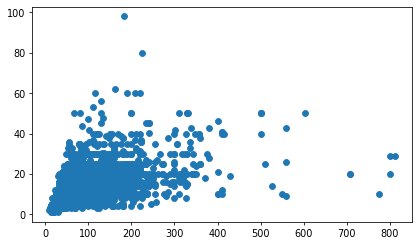

In [634]:
fig08 = plt.figure(figsize=(7, 4), dpi=70)
plt.scatter(x=b2['total_m2'], y=b2['kitchen_m2'])
plt.show()
# график очень сильно расширяется, разброс большой
# это и опдтверждает регресионный анализ

In [635]:
# модель по кухне слабая, но это все что есть
# лучше чем потерять несколько записей целиком
# применяем подготовленные модели

# коэффиуиент const - смотрим
kitchen_m2_const = model_kitchen01.params

for i in range(0, len(data)):
    if data.loc[i, 'kitchen_m2'] == 0:
        data.loc[i, 'kitchen_m2'] = int(model_kitchen01.predict([kitchen_m2_const.iloc[0], 
                                                              data.loc[i, 'total_m2'], 
                                                              data.loc[i, 'total_m2_x2'],
                                                              data.loc[i, 'live_m2'],
                                                              data.loc[i, 'live_m2_x2']
                                                              ])[0])
#data[['Площадь, м2', 'total_m2', 'live_m2', 'kitchen_m2']].head()


In [636]:
# удаляем ненужные столбцы
data = data.drop('Площадь, м2', axis=1) 
data = data.drop('live_m2_x2', axis=1) 
data = data.drop('total_m2_x2', axis=1) 

# Ремонт квартиры

In [637]:
 # какие типы ремонтов в массиве
set(data['Ремонт']) 

{nan, 'Без ремонта', 'Дизайнерский', 'Евроремонт', 'Косметический'}

In [638]:
# пустышек: 
len(data[data['Ремонт'].isna()]) # 2460

2460

In [639]:
# предлагаю NaN сделать первое значение
data.loc[data['Ремонт'].isna(), 'Ремонт'] = 'Без ремонта'


In [640]:
# пустышек не осталось: 
len(data[data['Ремонт'].isna()]) # 0

0

In [641]:
# кодируем
le01 = LabelEncoder()
le01.fit(data['Ремонт'])
data['remont'] = le01.transform(data['Ремонт'])

In [642]:
# удаляем лишнее
data = data.drop('Ремонт', axis=1) 

# Параметры санузла

In [643]:
len(set(data['Санузел'])) #21

21

In [644]:
set(data['Санузел'])
# даже если значение пропущено, то туалет все равно есть
# предположим что пропущенные значения - это совмещенный туалет
# удаляем NaN

{nan,
 'Раздельный (1)',
 'Раздельный (2)',
 'Раздельный (3)',
 'Раздельный (4)',
 'Совмещенный (1)',
 'Совмещенный (1), Раздельный (1)',
 'Совмещенный (1), Раздельный (2)',
 'Совмещенный (1), Раздельный (3)',
 'Совмещенный (2)',
 'Совмещенный (2), Раздельный (1)',
 'Совмещенный (2), Раздельный (2)',
 'Совмещенный (2), Раздельный (3)',
 'Совмещенный (2), Раздельный (4)',
 'Совмещенный (3)',
 'Совмещенный (3), Раздельный (1)',
 'Совмещенный (3), Раздельный (2)',
 'Совмещенный (3), Раздельный (3)',
 'Совмещенный (4)',
 'Совмещенный (4), Раздельный (1)',
 'Совмещенный (4), Раздельный (2)'}

In [645]:
data.loc[data['Санузел'].isna(), 'Санузел'] = 'Совмещенный (1)'
len(data[data['Санузел'].isna()]) # =0

0

In [646]:
# готовим новые столбцы
data['toilet_sep'] = 0 
data['toilet_unted'] = 0

In [647]:
for i in range(0,len(data)):
    if data.loc[i, 'Санузел'] is not np.NaN:
        balk = re.findall(r'\d+', data.loc[i, 'Санузел'])
        if len(balk)>1:
            data.loc[i, 'toilet_unted'], data.loc[i, 'toilet_sep'] = balk
        else:
            if re.match(r'^Раздельный', data.loc[i, 'Санузел']):
                data.loc[i, 'toilet_sep'] = balk[0]
            else:
                data.loc[i, 'toilet_unted'] = balk[0]

/tmp/ipykernel_177212/3751369422.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, 'toilet_unted'] = balk[0]
/tmp/ipykernel_177212/3751369422.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, 'toilet_unted'], data.loc[i, 'toilet_sep'] = balk


In [648]:
data[['Санузел', 'toilet_sep', 'toilet_unted']].tail(3) #ok

,Санузел,toilet_sep,toilet_unted
19527,Совмещенный (1),0,1
19528,"Совмещенный (1), Раздельный (1)",1,1
19529,Раздельный (1),1,0


In [649]:
data = data.drop('Санузел', axis=1) # удаляем ненужные столбцы
data['toilet_sep'] = data['toilet_sep'].astype(float)
data['toilet_unted'] = data['toilet_unted'].astype(float)

# Окна из квартиры

In [650]:
len(set(data['Окна'])) #19

4

In [651]:
# какие уникальные значения
set(data['Окна'])

{nan, 'Во двор', 'На улицу', 'На улицу и двор'}

In [652]:
len(data[data['Окна'].isna()]) # 5092 - очень много
# предположим что nan - это окна на улицу 

5092

In [653]:
data.loc[data['Окна'].isna(), 'Окна'] = 'Во двор'
len(data[data['Окна'].isna()]) # 0 - убрали все @metka

0

In [654]:
# кодируем
le01 = LabelEncoder()
le01.fit(data['Окна'])
data['windows'] = le01.transform(data['Окна'])

dict(zip(le01.classes_, range(len(le01.classes_)))) # а вот и словарь
# {'Во двор': 0, 'На улицу': 1, 'На улицу и двор': 2}

{'Во двор': 0, 'На улицу': 1, 'На улицу и двор': 2}

In [655]:
data = data.drop('Окна', axis=1) # удаляем ненужные столбцы

# Балкон

In [656]:
len(set(data['Балкон'])) # 19 - всего уникальных

19

In [657]:
set(data['Балкон'])

{nan,
 'Балкон (1)',
 'Балкон (1), Лоджия (1)',
 'Балкон (1), Лоджия (2)',
 'Балкон (1), Лоджия (3)',
 'Балкон (1), Лоджия (4)',
 'Балкон (2)',
 'Балкон (2), Лоджия (1)',
 'Балкон (2), Лоджия (2)',
 'Балкон (2), Лоджия (3)',
 'Балкон (3)',
 'Балкон (3), Лоджия (1)',
 'Балкон (3), Лоджия (3)',
 'Балкон (4)',
 'Балкон (4), Лоджия (4)',
 'Лоджия (1)',
 'Лоджия (2)',
 'Лоджия (3)',
 'Лоджия (4)'}

In [658]:
len(data[data['Балкон'].isna()]) # 6583 - очень много
# если балкон не указан - думаем что его нет

6583

In [659]:
data.loc[data['Балкон'].isna(), 'Балкон'] = 'Балкон (1)'
len(data[data['Балкон'].isna()]) # 6583 - очень много

0

In [660]:
# готовим новые столбцы
data['balcony'] = 0  # число балконов
data['loggia'] = 0 # число лоджий

In [661]:
data.loc[i, 'Балкон']

'Лоджия (1)'

In [662]:
for i in range(0,len(data)):
    if data.loc[i, 'Балкон'] is not np.NaN:
        if data.loc[i, 'Балкон'] != 'Нет':
            balk = re.findall(r'\d+', data.loc[i, 'Балкон'])
            if len(balk)>1:
                data.loc[i, 'balcony'], data.loc[i, 'loggia'] = balk
            if re.match(r'^Балкон', data.loc[i, 'Балкон']):
                data.loc[i, 'balcony'] = balk[0]
            else:
                data.loc[i, 'loggia'] = balk[0]

/tmp/ipykernel_177212/122677479.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, 'balcony'] = balk[0]
/tmp/ipykernel_177212/122677479.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, 'loggia'] = balk[0]


In [663]:
data = data.drop('Балкон', axis=1) #удаляем первоначальный столбец

In [664]:
data['balcony'] = data['balcony'].astype(float)
data['loggia'] = data['loggia'].astype(float)

# Количество комнат

In [665]:
len(set(data['Количество комнат'])) #25

25

In [666]:
#set(data['Количество комнат'])
# {'1',
#  '1, Изолированная',
#  '1, Оба варианта',
#  '1, Смежная',
#  '2',

- В колонке доступны две характристики - количество комнат и тип комнат.
    - разделяем характеристики из строки
    - будем считать что если количество комнат не указано, то она одна и изолированная (естественно)

In [667]:
# пропуски в первоначальных записях:
len(data[data['Количество комнат'].isna()]) # пропущенных 533 - неплохо, но многовато

533

In [668]:
# предположим что пропущенные значения -'1, Изолированная',
# удаляем NaN
data.loc[data['Количество комнат'].isna(), 'Количество комнат'] = '1, Изолированная'
len(data[data['Количество комнат'].isna()]) # =0 @metka

0

In [669]:
data['rooms_sep'] = 0 #Изолированных
data['rooms_unted'] = 0 # Смежных

In [670]:
for i in range(0,len(data)):
    if data.loc[i, 'Количество комнат'] is not np.NaN:
        balk = re.findall(r'\d+', data.loc[i, 'Количество комнат'])
        if len(data.loc[i, 'Количество комнат']) == 1: 
            # предположим что если указана просто цифра, то все комнаты изолированные
            data.loc[i, 'rooms_sep'] = balk[0]
        else: # еще дан комментарий
            if re.match(r'[а-яА-Я0-9., ]+Изолированная$', data.loc[i, 'Количество комнат']):
                data.loc[i, 'rooms_sep'] = balk[0]
            else: # иначе смежная
                if int(balk[0]) == 2:
                    data.loc[i, 'rooms_sep'], data.loc[i, 'rooms_unted'] = '1', '1'
                else:
                    f0 = int(int(balk[0])/3) # предположим одна смежная на две изолированных
                    data.loc[i, 'rooms_sep'], data.loc[i, 'rooms_unted'] = str(int(balk[0])-f0), str(f0)



/tmp/ipykernel_177212/3749969376.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, 'rooms_sep'] = balk[0]
/tmp/ipykernel_177212/3749969376.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, 'rooms_sep'], data.loc[i, 'rooms_unted'] = str(int(balk[0])-f0), str(f0)


In [671]:
data = data.drop('Количество комнат', axis=1) # удаляем ненужные столбцы

In [672]:
data['rooms_sep'] = data['rooms_sep'].astype(float)
data['rooms_unted'] = data['rooms_unted'].astype(float)

In [673]:
# добавим дополнительный столбец с общим количеством комнат
data['rooms'] = data['rooms_sep'] + data['rooms_unted']

In [674]:
# смотрим на количество пропущенных значений:
# полное количество комнат
len(data[data['rooms'].isna()]) #0

0

In [675]:
# количество смежных комнат
len(data[data['rooms_unted'].isna()]) #0

0

In [676]:
# количество изолированных комнат
len(data[data['rooms_sep'].isna()]) #0

0

# Высота потолков

In [677]:
len(set(data['Высота потолков, м'])) #9209

9209

In [678]:
#set(data['Высота потолков, м']) # уникальные
# {2.5,
#  3.5,
#  3.0,
#  4.0,
#  5.5,
#  ...

In [679]:
len(data[data['Высота потолков, м'].isna()]) # 9120 - очень много

9120

In [680]:
data['Высота потолков, м'].describe()
# куча nan и много странных высот
# есть значения 32 и 320

count    10410.000000
mean         2.996952
std          7.899654
min          1.200000
25%          2.640000
50%          2.640000
75%          2.800000
max        320.000000
Name: Высота потолков, м, dtype: float64

In [681]:
#data['Высота потолков, м'] = data['Высота потолков, м'].astype(str)
data.loc[data['Высота потолков, м'].isna(), 'Высота потолков, м'] = 2.5 
# поставим нечто среднее
data.loc[data['Высота потолков, м'] == 'Не указан', 'Высота потолков, м'] = 2.5 
# поставим нечто среднее
data['Высота потолков, м'] = data['Высота потолков, м'].astype(float)
data['Высота потолков, м'].describe()

count    19530.000000
mean         2.764888
std          5.772627
min          1.200000
25%          2.500000
50%          2.500000
75%          2.640000
max        320.000000
Name: Высота потолков, м, dtype: float64

In [682]:
# корректируем очень высокие потолки - от 13 метров
for i in range(0, len(data['Высота потолков, м'])):
    if data.loc[i, 'Высота потолков, м'] > 100:
        data.loc[i, 'Высота потолков, м'] = data.loc[i, 'Высота потолков, м'] / 100
    if data.loc[i, 'Высота потолков, м'] > 13:
        data.loc[i, 'Высота потолков, м'] = data.loc[i, 'Высота потолков, м'] / 10


In [683]:
data.loc[data['Высота потолков, м']<2,'Высота потолков, м'] = 2.5
data.loc[data['Высота потолков, м']>7, 'Высота потолков, м'] = 6.0
data['Высота потолков, м'].describe()

count    19530.000000
mean         2.637680
std          0.238795
min          2.000000
25%          2.500000
50%          2.500000
75%          2.640000
max          6.000000
Name: Высота потолков, м, dtype: float64

In [684]:
data['ceiling'] = data['Высота потолков, м']
data = data.drop('Высота потолков, м', axis=1)

In [685]:
data['ceiling'] = data['ceiling'].astype(float)

# Мусоропровод 

In [686]:
set(data['Мусоропровод']) #{'Нет', 'Да', nan}

{nan, 'Да', 'Нет'}

In [687]:
# пустышек: 
len(data[data['Мусоропровод'].isna()]) # 8007

7977

In [688]:
# считаем что все квартиры в москве
d1 = list(set(data['street']))
for i in d1:
    # выбираем одну улицу
    data10 = data[data['street'] == i]
    #делаем список по всем домам
    d2 = list(set(data10['house']))
    for j in d2:
        #выбираем один дом
        data22 = data10[data10['house'] == j]
        if len(data22) > 1 :
            #смотрим на все мусоропроводы
            d3 = list(set(data22['Мусоропровод']))
            if len(d3) == 2:
                if d3[0] == 'NaN':
                    dd10 = d3[1]
                else:
                    dd10 = d3[0]
                # вносим изменения в основую таблицу
                data.loc[((data['street']==i) & (data['house']==j)), 'Мусоропровод'] = dd10


In [689]:
# проверяем как изменились пустышки 
len(data[data['Мусоропровод'].isna()]) # 4979

4960

In [690]:
# предположим что все-таки есть мусоропровод 
data.loc[data['Мусоропровод'].isna(), 'Мусоропровод'] = 'Нет'
# data.loc[data['Мусоропровод'] == '2.5', 'Мусоропровод'] = 'Нет'
# data.loc[data['Мусоропровод'] == '6.0', 'Мусоропровод'] = 'Нет'
len(data[data['Мусоропровод'].isna()]) # 0

0

In [691]:
data['Мусоропровод'] = data['Мусоропровод'].astype(str)

In [692]:
# кодируем
le01 = LabelEncoder()
le01.fit(data['Мусоропровод'])
data['g_chute'] = le01.transform(data['Мусоропровод'])
dict(zip(le01.classes_, range(len(le01.classes_)))) # а вот и словарь

{'Да': 0, 'Нет': 1}

In [693]:
data = data.drop('Мусоропровод', axis=1)

# Удаленность от метро

In [694]:
data = data.reset_index(drop=True)
len(set(data['Метро'])) #4872

4857

In [695]:
# set(data['Метро'])
# 'м. Кузьминки (2 мин пешком)',
#  'м. Нагатинская (16 мин пешком)',
#  'м. Алма-Атинская (13 мин на машине)',
#  'м. Бауманская (8 мин пешком)',
# ...

In [696]:
data['Метро'] = data['Метро'].astype(str)
len(data[data['Метро'].isna()]) # 0 - записи есть по всем позициям

0

In [697]:
# и еще
# 36           м. Смоленская (None мин пешком)
# 61             м. Киевская (None мин пешком)
# убираемм этот мусор
data.loc[(data['Метро'].str.find('None') >=0), 'Метро'] = '0'
len(data[data['Метро'].isna()]) # 0 -  все ушло в 0

0

In [698]:
# посмотрим на  0
len(data[data['Метро'] == '0']) # 534

534

In [699]:
# в одном доме может быть несколько квартиир
# при этом не все пишут сколько врмеени до метро
# делаем список по всем улицам
d1 = list(set(data['street']))
for i in d1:
    # выбираем одну улицу
    data10 = data[data['street'] == i]
    #делаем список по всем домам
    d2 = list(set(data10['house']))
    for j in d2:
        #выбираем один дом
        data22 = data10[data10['house'] == j]
        if len(data22) > 1 :
            #смотрим на все указания метро
            d3 = list(set(data22['Метро']))
            d3 = [x for x in d3 if str(x) != '0']
            if len(d3) >0:
                #data.loc[((data['street']==i) & (data['house']==j)) & (data['Метро'].isna()), 'Метро'] = d3[0]
                data.loc[((data['street']==i) & (data['house']==j)), 'Метро'] = d3[0]

In [700]:
# посмотрим на  0
len(data[data['Метро'] == '0']) # 162

162

In [701]:
# готовим новые столбцы
data['metro_walk'] = '0'
data['metro_drive'] = '0'
# предположу что ставить два столбца об одном и том же не имеет смысла
# разделим в начале, потом сведем к одному столбцу

In [702]:
# разносим время по двум столбцам из строки описания
for i in range(0,len(data)):
    if data.loc[i, 'Метро'] is not np.NaN:
        balk = re.findall(r'\d+', data.loc[i, 'Метро'])
        if len(balk) > 0:
            if len(balk) == 1:
                k = 0
            else:
                k = 1
            #if re.match(r'[а-яА-Я0-9.,?() ]+пешком\)$', data.loc[i, 'Метро']):
            if data.loc[i, 'Метро'] .find('пешком') >= 0:
                data.loc[i, 'metro_walk'] = balk[k]
            else:
                data.loc[i, 'metro_drive'] = balk[k]
                
data[['Метро', 'metro_walk', 'metro_drive']].tail(10)

,Метро,metro_walk,metro_drive
19520,м. Солнцево (4 мин пешком),4,0
19521,м. Говорово (11 мин пешком),11,0
19522,м. Солнцево (5 мин на машине),0,5
19523,м. Солнцево (18 мин пешком),18,0
19524,м. Говорово (7 мин пешком),7,0
19525,м. Говорово (4 мин пешком),4,0
19526,м. Солнцево (7 мин пешком),7,0
19527,м. Солнцево (6 мин пешком),6,0
19528,м. Солнцево (11 мин пешком),11,0
19529,м. Говорово (10 мин пешком),10,0


In [703]:
# посмотрим на нулевые записи
len(data[(data['metro_walk'] == '0') & (data['metro_drive'] == '0')]) #489
# почему стало больше??

489

In [704]:
data['metro_drive'] = data['metro_drive'].astype(float)
data['metro_walk'] = data['metro_walk'].astype(float)

In [705]:
data = data.drop('Метро', axis=1) # удаляем ненужные столбцы

In [706]:
# на машине в городе скорость 25 км.ч
# пешком пусть будет 4 км.ч
# пусть проехать придется на 30% больше чем идти
# то есть 25/4.5*1.1 = 6.11

for i in range(0,len(data)):
    if data.loc[i, 'metro_walk'] == 0:
        if data.loc[i, 'metro_drive'] > 0:
            data.loc[i, 'metro_walk'] = data.loc[i, 'metro_drive'] * 25/4.5*1.1

#data.loc[1240:1260, ['metro.drive', 'metro.walk']] # посмотрим?

In [707]:
data = data.drop('metro_drive', axis=1) # удаляем ненужные столбцы

In [708]:
# проверяем как изменились пустышки 
len(data[data['metro_walk'].isna()]) 
#  пустышек не осталось

0

In [709]:
# а сколько нулей?
len(data[data['metro_walk'] == 0]) #489

489

In [710]:
data.loc[data['metro_walk'] == 0, 'metro_walk'] = data['metro_walk'].median()

In [711]:
# а сколько нулей?
len(data[data['metro_walk'] == 0]) #0

0

# Парковка

In [712]:
len(set(data['Парковка'])) #6
# {'многоуровневая', 'подземная', nan, 'наземная', 'на крыше', 'открытая'}

6

In [713]:
len(data[data['Парковка'].isna()]) # 10567 - очень много
# парковка наверняка есть, видимо наземная вогкруг дома 
# и ограниченная по объему
# предположим что пропущенные значения - это наземная

11045

In [714]:
# удаляем NaN
data.loc[data['Парковка'].isna(), 'Парковка'] = 'открытая'
len(data[data['Парковка'].isna()]) # =0 @Metka

0

In [715]:
# кодируем
le01 = LabelEncoder()
le01.fit(data['Парковка'])
data['parking'] = le01.transform(data['Парковка'])
dict(zip(le01.classes_, range(len(le01.classes_)))) # а вот и словарь

{'многоуровневая': 0,
 'на крыше': 1,
 'наземная': 2,
 'открытая': 3,
 'подземная': 4}

In [716]:
data = data.drop('Парковка', axis=1) # удаляем ненужные столбцы

# Дополнительное описание квартиры

In [717]:
len(set(data['Дополнительно'])) #529
# 'Мебель в комнатах, Ванна, Стиральная машина, Кондиционер, 
# Телевизор, Интернет', 'Мебель в комнатах, Мебель на кухне, 
# Ванна, Кондиционер, Посудомоечная машина, Телевизор, Холодильник, 
# Интернет, Телефон', 'Мебель в комнатах,

489

In [718]:
#set(data['Дополнительно']) # составляющих много

In [719]:
len(data[data['Дополнительно'].isna()]) # 232 - много

267

In [720]:
# если не указано - не сможем вытащить откуда-то
data.loc[data['Дополнительно'].isna(), 'Дополнительно'] = ''

In [721]:
# надо разделить по составляющим и сделать сет
c1 = set()
i = 0
for i in range(0, len(data)):
    c1.update(set(data.loc[i, 'Дополнительно'].split(', ')))

In [722]:
# что получилось?
len(c1) #12
c1

{'',
 'Ванна',
 'Душевая кабина',
 'Интернет',
 'Кондиционер',
 'Мебель в комнатах',
 'Мебель на кухне',
 'Посудомоечная машина',
 'Стиральная машина',
 'Телевизор',
 'Телефон',
 'Холодильник'}

In [723]:
# делаем словарь
additional_list = ['Телевизор', 'Душевая кабина', 'Ванна', 'Мебель в комнатах', 
 'Кондиционер', 'Телефон', 'Стиральная машина', 'Мебель на кухне', 
 'Холодильник', 'Интернет', 'Посудомоечная машина']
# 'TV', 'Shower cabin', 'Bathtub', 'Furniture in the rooms', 
#  'Air conditioning', 'Telephone', 'Washing machine', 'Kitchen furniture', 
#  'Refrigerator', 'Internet', 'Dishwasher']
additional_key = ['tv', 'shower_cabin', 'bathtub', 'furniture',
'ac', 'telephone', 'washing_machine', 'kitchen_furniture',
'frig', 'internet', 'dishwasher']
additional_dict = dict(zip(additional_list, additional_key))
additional_dict

{'Телевизор': 'tv',
 'Душевая кабина': 'shower_cabin',
 'Ванна': 'bathtub',
 'Мебель в комнатах': 'furniture',
 'Кондиционер': 'ac',
 'Телефон': 'telephone',
 'Стиральная машина': 'washing_machine',
 'Мебель на кухне': 'kitchen_furniture',
 'Холодильник': 'frig',
 'Интернет': 'internet',
 'Посудомоечная машина': 'dishwasher'}

In [724]:
# делаем столбцы
data['tv'] = 0
data['shower_cabin'] = 0
data['bathtub'] = 0
data['furniture'] = 0
data['ac'] = 0
data['telephone'] = 0
data['washing_machine'] = 0
data['kitchen_furniture'] = 0
data['frig'] = 0
data['internet'] = 0
data['dishwasher'] = 0

In [725]:
# собираем список ключей
all_keys = list(additional_dict.keys())

# разносим все по подготовленным столбцам
for i in range(0, len(data)) :
    for j in range(0, len(all_keys)) :
        if data.loc[i, 'Дополнительно'] != '':
            if data.loc[i, 'Дополнительно'].find(all_keys[j]) >= 0:
                data.loc[i, additional_dict[all_keys[j]]] = 1


In [726]:
# проверяем что получилось
data.loc[0, ['Дополнительно', 'tv', 'shower_cabin', 'bathtub', 'furniture',
    'ac', 'telephone', 'washing_machine', 'kitchen_furniture', 'frig',
    'internet', 'dishwasher']]

Дополнительно        Мебель в комнатах, Мебель на кухне, Ванна, Душ...
tv                                                                   1
shower_cabin                                                         1
bathtub                                                              1
furniture                                                            1
ac                                                                   1
telephone                                                            1
washing_machine                                                      1
kitchen_furniture                                                    1
frig                                                                 1
internet                                                             1
dishwasher                                                           1
Name: 0, dtype: object

In [727]:
# удаляем ненужное
data = data.drop('Дополнительно', axis=1) # удаляем ненужные столбцы

# Описание дома

In [728]:
len(set(data['Дом'])) #2310

2401

In [729]:
#set(data['Дом']) # - много

In [730]:
# смотрим сколько НаН
len(data[data['Дом'].isna()]) # 0 - интересно

0

In [731]:
# распознаем описание дома
c11 = data['Дом'].str.split(', ', expand=True)
c12 = c11.loc[:, 0].str.split('/', expand=True)
c11['floor'] = c12.loc[:, 0]
c11['tot_floor'] = c12.loc[:, 1]
c11['street'] = data.loc[:, 'street']
c11['house'] = data.loc[:, 'house']
c11.head()
#получили три столбца, смотрим на состав

,0,1,floor,tot_floor,street,house
0,5/16,Монолитный,5,16,1579,877
1,5/16,Монолитно-кирпичный,5,16,1579,877
2,5/16,None,5,16,1579,877
3,5/6,None,5,6,1180,729
4,12/26,Панельный,12,26,1579,400


In [732]:
#set(c11.loc[:, 1])
#{None, 'Монолитный', 'Кирпичный', 'Монолитно-кирпичный', 'Панельный', 
# 'Деревянный', 'Газобетонный блок', 'Щитовой', 'старый фонд', 'Блочный', 
# 'Сталинский'}

In [733]:
len(c11[c11.loc[:, 1].isna()]) # 2714

2936

In [734]:
len(c11[c11.loc[:, 'floor'].isna()]) # 0

0

In [735]:
len(c11[c11.loc[:, 'tot_floor'].isna()]) # 0

0

In [736]:
# поиск по другим квартирам в доме - как в Метро
# делаем список по всем улицам
d1 = list(set(c11['street']))
for i in d1:
    # выбираем одну улицу
    data10 = c11[c11['street'] == i]
    #делаем список по всем домам
    d2 = list(set(data10['house']))
    for j in d2:
        #выбираем один дом
        data22 = data10[data10['house'] == j]
        if len(data22) > 1 :
            #смотрим на все указания 
            d3 = list(set(data22.loc[:, 1]))
            d3 = [x for x in d3 if str(x) != 'None']
            if len(d3) >0:
                c11.loc[(c11['street']==i) & (c11['house']==j), 1] = d3[0]


In [737]:
# что изменилось?
len(c11[c11.loc[:, 1].isna()]) # 1030

1080

In [738]:
# попробуем вот так заменить НаН
c11.loc[c11.loc[:, 1].isna(), 1] = 'Панельный' # @Metka

In [739]:
# переносим в основной массив
data['house_type'] = c11.loc[:, 1]
data['floor'] = c11.loc[:, 'floor']
data['tot_floor'] = c11.loc[:, 'tot_floor']

In [740]:
# убираем лишнее
del c11
data = data.drop('Дом', axis=1) # удаляем ненужные столбцы

In [741]:
# кодируем
le01 = LabelEncoder()
le01.fit(data['house_type'])
data['house_type'] = le01.transform(data['house_type'])
dict(zip(le01.classes_, range(len(le01.classes_)))) # а вот и словарь

{'Блочный': 0,
 'Деревянный': 1,
 'Кирпичный': 2,
 'Монолитно-кирпичный': 3,
 'Монолитный': 4,
 'Панельный': 5,
 'Сталинский': 6,
 'Щитовой': 7,
 'старый фонд': 8}

In [742]:
data['floor'] = data['floor'].astype(int)
data['tot_floor'] = data['tot_floor'].astype(int)

In [743]:
# дополнительные поля
data['floor1'] = 0
data.loc[data['floor']  == 1,'floor1'] = 1
data['floor_c1'] = round(20/data['floor'], ndigits=0).astype(int)

## Площадь комнат

In [744]:
len(set(data['Площадь комнат, м2'])) #3330

3448

In [745]:
# Число пропущенных ячеек велико, предлагаю не рассматривать данный столбец
data = data.drop('Площадь комнат, м2', axis=1) # удаляем ненужные столбцы

## Название ЖК

In [746]:
len(set(data['Название ЖК'])) #1097

1128

In [747]:
# смотрим сколько НаН
len(data[data['Название ЖК'].isna()]) # 14554 
# пропусков очень много, не вижу смысла использовать столбец

15090

In [748]:
data = data.drop('Название ЖК', axis=1) # удаляем ненужные столбцы

## Серия дома

In [749]:
len(set(data['Серия дома'])) #364

369

In [750]:
# смотрим сколько НаН
len(data[data['Серия дома'].isna()]) # 16626
# пропусков очень много, не вижу смысла использовать столбец

17442

In [751]:
data = data.drop('Серия дома', axis=1) # удаляем ненужные столбцы

# Тип

In [752]:
len(set(data['Тип'])) #364

1

In [753]:
# смотрим сколько НаН
len(data[data['Тип'].isna()]) # 
# пропусков очень много, не вижу смысла использовать столбец

0

In [754]:
# столбец не имеет смысла для анализа - удаляем
data = data.drop('Тип', axis=1)

## 21. Лифт

In [755]:
len(set(data['Лифт'])) #34

34

In [756]:
#set(data['Лифт'])
# {nan,
#  'Груз (1)',
#  'Груз (2)',
#  'Груз (3)',
#  'Груз (4)',
#  'Груз (6)',
#  'Груз (8)',
#  'Пасс (1)',
#  'Пасс (1), Груз (1)',

In [757]:
# смотрим сколько НаН
len(data[data['Лифт'].isna()]) # 4180 - очень много

4180

In [758]:
# поиск по другим квартирам в доме - как в Метро
# делаем список по всем улицам
d1 = list(set(data['street']))
for i in d1:
    # выбираем одну улицу
    data10 = data[data['street'] == i]
    #делаем список по всем домам
    d2 = list(set(data10['house']))
    for j in d2:
        #выбираем один дом
        data22 = data10[data10['house'] == j]
        if len(data22) > 1 :
            #смотрим на все указания 
            d3 = list(set(data22.loc[:, 'Лифт']))
            d3 = [x for x in d3 if str(x) != 'nan']
            if len(d3) >0:
                data.loc[((data['street']==i) & (data['house']==j) & (data['Лифт'].isna())), 'Лифт'] = d3[0]
                #data['Метро'].isna()

In [759]:
# смотрим сколько НаН
len(data[data['Лифт'].isna()]) # стало вдвое лучше

2600

In [760]:
# попробуем версия с малоэтажками - если 5 этажей или меньше - лифта нет
data.loc[(data['Лифт'].isna()) & (data['tot_floor'] <= 5), 'Лифт'] = '0'


In [761]:
# смотрим сколько НаН
len(data[data['Лифт'].isna()]) # 410

410

In [762]:
# остальным сделаем традиционно - по одному 
data.loc[data['Лифт'].isna(), 'Лифт'] = 'Пасс (1), Груз (1)'

In [763]:
# смотрим сколько НаН
len(data[data['Лифт'].isna()]) # 0!

0

In [764]:
#['Пасс (1), Груз (1)', 'Пасс (2)']
data['elev_pass'] = 0
data['elev_serv'] = 0

In [765]:
for i in range(0, len(data)):
    if data.loc[i, 'Лифт'] != '0':
        if data.loc[i, 'Лифт'].find(',') <0: # только один тип лифта
            numb_lift = int(re.findall(r'\d+', data.loc[i, 'Лифт'])[0])
            if data.loc[i, 'Лифт'].find('Пасс') >=0:
                data.loc[i, 'elev_pass'] = numb_lift
            else:
                data.loc[i, 'elev_serv'] = numb_lift
        else: #два типа лифта            
            b10, b11 = data.loc[i, 'Лифт'].split(',')
            data.loc[i, 'elev_pass'] = int(*re.findall(r'\d+', b10))
            data.loc[i, 'elev_serv'] = int(*re.findall(r'\d+', b11))

In [766]:
# смотрим сколько НаН
len(data[data['elev_pass'].isna()]) # 0!

0

In [767]:
# смотрим сколько НаН
len(data[data['elev_serv'].isna()]) # 0!

0

In [768]:
data = data.drop('Лифт', axis=1) # удаляем ненужные столбцы

## 16. Можно с детьми и животными

In [769]:
len(set(data['Можно с детьми/животными'])) #4

4

In [770]:
set(data['Можно с детьми/животными'])

{nan,
 'Можно с детьми',
 'Можно с детьми, Можно с животными',
 'Можно с животными'}

In [771]:
# смотрим сколько НаН
len(data[data['Можно с детьми/животными'].isna()]) # 4871 - очень много

4871

In [772]:
data['child'] = 0
data['animal'] = 0

In [773]:
data.loc[data['Можно с детьми/животными'].isna(), 'Можно с детьми/животными'] = 'None'

In [774]:
for i in range(0, len(data)):
    if data.loc[i, 'Можно с детьми/животными'] != 'None':
        if data.loc[i, 'Можно с детьми/животными'].find('детьми') >=0:
            data.loc[i, 'child'] = 1
        if data.loc[i, 'Можно с детьми/животными'].find('животными') >=0:
            data.loc[i, 'animal'] = 1

In [775]:
# проверим
data.loc[0, ['Можно с детьми/животными', 'child', 'animal']]

Можно с детьми/животными    Можно с детьми, Можно с животными
child                                                       1
animal                                                      1
Name: 0, dtype: object

In [776]:
data = data.drop('Можно с детьми/животными', axis=1) # удаляем ненужные столбцы

## Предварительная оценка 

In [777]:
# Описание столцов:
#  1 - city - город расположения объекта / Адрес
#  2 - street - улица расположения объекта / Адрес
#  3 - house - номер дома где располагается объект / Адрес
#  4 - price - стоимость арнеды в месяц, руб / Цена
#  5 - utilities_cost - расходы на коммунальные услуги в месяц, руб, если указаны. 
#         0 - если не указаны / Цена
#  6 - deposit - демозит при аренде квартиры, руб / Цена  
#  7 - utilities_included - вклюбчены ли коммунальные услуги в стоимость арнеды, 
#         1 = вклоючены, 0 = не включены / Цена
#  8 - rent_length - минимальная длительность аренды, мес / Цена
#  9 - price_advance - авансовый платеж за несколько месяцев 
#   вперед, в месяцах / Цена   <удален>
# 10 - total_m2 - Общая площадь, м2 / Площадь
# 11 - live_m2 - Жилая площадь, м2 / Площадь
# 12 - kitchen_m2 - Площадь кухни, м2 / Площадь 
# 12A- remont - тип ремонта квартиры
# 14 - toilet_sep - число изолированных санузлов
# 15 - toilet_unted - число совмещенных санузлов
# 16 - windows - направление окон из квартиры
# 17 - balcony - число балконов в квартире
# 18 - loggia - число лоджий в квартире
# 19 - rooms_sep - изолированных комнат
# 20 - rooms_unted - смежных комнат
# 21 - ceiling - высота потолков
# 22 - g_chute - мусоропровод
# 23 - metro_walk - пешком до метро, мин
# 24 - parking - какая парковка 
# 25 - tv - наличие телевизора/дополнительное
# 26 - shower_cabin - наличие душевой кабины/дополнительное
# 27 - bathtub - наличие ванной/дополнительное
# 28 - furniture - наличие мебели в квартире/дополнительное
# 29 - ac - наличие кондиционера/дополнительное
# 30 - telephone - наличие телефона/дополнительное
# 31 - washing_machine - наличие стиральной машны/дополнительное
# 32 - kitchen_furniture - наличие мебели на кухне/дополнительное
# 33 - frig - наличие холодильника/дополнительное
# 34 - internet - наличие интернета/дополнительное
# 35 - dishwasher - наличие посудомойки/дополнительное
# 36 - house_type - тип дома (материал)
# 37 - floor - этаж дома
# 38 - tot_floor - всего этажей в доме
# 39 - elev_serv - число грузовых лифтов
# 40 - elev_pass - число пассажирских лифтов
# 41 - animal - можно с животными
# 42 - child


In [778]:
pd.DataFrame(data.isnull().sum().sort_values(ascending=False), 
             columns=['Число пропущенных'])

,Число пропущенных
Ссылка на объявление,0
metro_walk,0
tv,0
shower_cabin,0
bathtub,0
furniture,0
ac,0
telephone,0
washing_machine,0
kitchen_furniture,0


In [779]:
round(len(data.dropna(axis = 0))/len(data)*100, ndigits=2)
#df = df.dropna(axis = 0)

100.0

In [780]:
data.shape

(19530, 45)

In [781]:
# смотрим на массив до обрезки:
#data.head(3)

In [782]:
column_type(data)

,Columns,Type
0,Ссылка на объявление,<class 'str'>
1,street,<class 'numpy.int64'>
2,house,<class 'numpy.int64'>
3,price,<class 'numpy.float64'>
4,utilities_cost,<class 'numpy.float64'>
5,deposit,<class 'numpy.float64'>
6,utilities_included,<class 'numpy.int64'>
7,rent_length,<class 'numpy.float64'>
8,price_advance,<class 'numpy.float64'>
9,total_m2,<class 'numpy.float64'>


In [783]:
data['total_m2_x05'] = data['total_m2'] ** 0.5
data['total_m2_x2'] = data['total_m2'] ** 2

In [784]:
# оставляем для анализа только необходимые столбцы:
data2 = data[['street', 'house', 'utilities_included',
              'rent_length', 'total_m2', 
              'total_m2_x2', 'total_m2_x05',
              'live_m2', 'kitchen_m2', 'remont', 'toilet_sep', 
              'toilet_unted', 'windows', 'balcony', 'loggia',
              'rooms_sep', 'rooms_unted', 'deposit', 'price_advance',
              'ceiling', 'g_chute', 'metro_walk', 'parking',
              'tv', 'shower_cabin', 'shower_cabin', 'bathtub',
              'furniture', 'ac', 'telephone', 'washing_machine',
              'kitchen_furniture', 'frig', 'internet', 'dishwasher',
              'floor', 'tot_floor', 'house_type',
              'floor1', 'floor_c1', 'rooms', 'elev_serv', 'elev_pass',
              'animal', 'child', 
              'price']]

# заодно все сохраняем:
# --- ---  save it here -----------------


In [785]:
# комплект от таблицы корреляции

data_corr = data[['bathtub', 
                  'ac', 'dishwasher','ceiling','rooms',
                  'total_m2', 'toilet_unted','parking',
                  'remont', 'windows', 'price'
                  ]]

              #'street', 'house', 'utilities_included',
            #   'rent_length', 'total_m2', 
            #   'total_m2_x2', 'total_m2_x05',
            #   'live_m2', 'kitchen_m2', 'remont', 'toilet_sep', 
            #   'toilet_unted', 'windows', 'balcony', 'loggia',
            #   'rooms_sep', 'rooms_unted', 'deposit', 'price_advance',
            #   'ceiling', 'g_chute', 'metro_walk', 'parking',
            #   'tv',  'shower_cabin', 'bathtub',
            #   'furniture',  'telephone', 'washing_machine',
            #   'kitchen_furniture', 'frig', 'internet', 
            #   'floor', 'tot_floor', 'house_type',
            #   'floor1', 'floor_c1', 'rooms',
            #   'price']]

In [786]:
#data2 = data_corr.copy()

In [787]:
# смотрим на массив:
data2.head()

,street,house,utilities_included,rent_length,total_m2,total_m2_x2,total_m2_x05,live_m2,kitchen_m2,remont,...,tot_floor,house_type,floor1,floor_c1,rooms,elev_serv,elev_pass,animal,child,price
0,1579,877,1,12.0,200.0,40000.0,14.142136,145.0,20.0,1,...,16,3,0,4,4.0,1,4,1,1,500000.0
1,1579,877,1,12.0,198.0,39204.0,14.071247,95.0,18.0,1,...,16,3,0,4,4.0,1,1,0,1,500000.0
2,1579,877,0,12.0,200.0,40000.0,14.142136,116.0,4.0,2,...,16,3,0,4,4.0,0,1,0,1,500000.0
3,1180,729,0,12.0,170.0,28900.0,13.038405,95.0,17.0,2,...,6,2,0,4,4.0,0,1,1,0,400000.0
4,1579,400,1,12.0,58.0,3364.0,7.615773,38.0,5.0,2,...,26,4,0,2,2.0,1,1,0,0,225000.0


In [788]:
# посмотрим на числовые данные
data2.describe()

,street,house,utilities_included,rent_length,total_m2,total_m2_x2,total_m2_x05,live_m2,kitchen_m2,remont,...,tot_floor,house_type,floor1,floor_c1,rooms,elev_serv,elev_pass,animal,child,price
count,19530.000000,19530.000000,19530.000000,19530.000000,19530.000000,19530.000000,19530.000000,19530.000000,19530.000000,19530.000000,...,19530.00000,19530.000000,19530.000000,19530.000000,19530.000000,19530.000000,19530.000000,19530.000000,19530.000000,1.953000e+04
mean,875.575627,988.377727,0.891551,11.748387,63.685873,6373.081094,7.641454,41.772002,11.622524,1.963902,...,14.47445,3.661086,0.055760,4.903687,2.003328,0.424526,1.384127,0.318433,0.740092,8.846198e+04
std,471.502954,555.721890,0.310954,1.483685,48.138439,18982.846448,2.300940,33.056600,6.335750,1.020291,...,9.07692,1.578631,0.229464,4.554470,1.006833,0.664193,1.166779,0.465880,0.438595,1.360302e+05
min,0.000000,0.000000,0.000000,3.000000,7.000000,49.000000,2.645751,4.000000,1.000000,0.000000,...,1.00000,0.000000,0.000000,-20.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.200000e+04
25%,484.250000,553.000000,1.000000,12.000000,38.900000,1513.210000,6.236986,20.000000,7.000000,1.000000,...,9.00000,2.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,4.000000e+04
50%,850.000000,974.000000,1.000000,12.000000,49.900000,2490.010000,7.063993,32.000000,10.000000,2.000000,...,12.00000,4.000000,0.000000,3.000000,2.000000,0.000000,1.000000,0.000000,1.000000,5.000000e+04
75%,1275.000000,1458.000000,1.000000,12.000000,70.000000,4900.000000,8.366600,49.000000,15.000000,3.000000,...,17.00000,5.000000,0.000000,7.000000,3.000000,1.000000,2.000000,1.000000,1.000000,7.500000e+04
max,1733.000000,1998.000000,1.000000,12.000000,811.000000,657721.000000,28.478062,640.000000,98.000000,3.000000,...,116.00000,8.000000,1.000000,20.000000,6.000000,12.000000,60.000000,1.000000,1.000000,3.000000e+06


In [789]:
# размеры
data2.shape

(19530, 46)

## Корелляционная матрица

In [790]:
correlation_matrix = data2.corr()
# plot = plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title(f'Тепловая карта корреляции')
# plt.show()
correlation_matrix

,street,house,utilities_included,rent_length,total_m2,total_m2_x2,total_m2_x05,live_m2,kitchen_m2,remont,...,tot_floor,house_type,floor1,floor_c1,rooms,elev_serv,elev_pass,animal,child,price
street,1.000000,-0.042841,0.010102,0.012776,-0.010465,-0.018977,-0.003819,-0.013590,-0.010130,0.031059,...,-0.030865,0.005298,0.003770,-0.002959,-0.000446,-0.006654,-0.003326,0.006480,0.015704,-0.023413
house,-0.042841,1.000000,-0.008997,0.010861,0.025552,0.015222,0.028992,0.029682,0.018717,-0.012161,...,-0.003345,-0.019925,-0.000551,0.000757,0.027180,0.008371,-0.007112,-0.000288,0.005271,0.002220
utilities_included,0.010102,-0.008997,1.000000,-0.045163,-0.276639,-0.185458,-0.282477,-0.299516,-0.196826,0.065454,...,-0.008493,-0.044836,0.015143,-0.005387,-0.238784,-0.000955,0.061476,-0.022466,0.052006,-0.290302
rent_length,0.012776,0.010861,-0.045163,1.000000,0.053451,0.028363,0.066256,0.040110,0.010486,-0.001129,...,-0.002804,0.025176,-0.030531,-0.026024,0.054549,-0.017401,-0.010986,0.012577,0.032641,0.035862
total_m2,-0.010465,0.025552,-0.276639,0.053451,1.000000,0.857364,0.969861,0.935229,0.599922,-0.207937,...,0.091788,-0.003111,-0.052433,-0.049354,0.795887,0.021060,0.045373,0.112456,0.110225,0.784598
total_m2_x2,-0.018977,0.015222,-0.185458,0.028363,0.857364,1.000000,0.721354,0.767593,0.432399,-0.120929,...,0.029014,-0.012903,-0.004234,-0.001021,0.515699,0.000531,0.011892,0.074817,0.049129,0.678785
total_m2_x05,-0.003819,0.028992,-0.282477,0.066256,0.969861,0.721354,1.000000,0.919956,0.614219,-0.227063,...,0.123222,0.006388,-0.079724,-0.081423,0.862942,0.030308,0.062748,0.118894,0.144401,0.740470
live_m2,-0.013590,0.029682,-0.299516,0.040110,0.935229,0.767593,0.919956,1.000000,0.589922,-0.211636,...,0.075285,-0.015394,-0.045267,-0.036566,0.802212,-0.003545,0.042752,0.123040,0.097685,0.766856
kitchen_m2,-0.010130,0.018717,-0.196826,0.010486,0.599922,0.432399,0.614219,0.589922,1.000000,-0.198411,...,0.236108,0.017705,-0.085571,-0.117770,0.445209,0.126653,0.152802,0.035907,-0.002268,0.521398
remont,0.031059,-0.012161,0.065454,-0.001129,-0.207937,-0.120929,-0.227063,-0.211636,-0.198411,1.000000,...,-0.149290,0.011511,0.042280,0.053599,-0.189102,-0.209057,-0.044527,-0.003394,0.008326,-0.221492


In [791]:
# пробуем модель
live01 = sm.add_constant(data2.iloc[:, :-1])
model_live01 = OLS(data2.loc[:, 'price'], live01, hasconst=True)
results_live01 = model_live01.fit()
print(results_live01.summary())

# R-squared:
#   вер 1 от 27-12-2024 : 0.085 
#   вер 2 от 28-12-2024 : 0.635
#   вер 3 от 28-12-2024 : 0.643 (+toilets)
#   вер 4 от 28-12-2024 : 0.647 (+balkony)
#   вер 5 от 28-12-2024 : 0.658 (+rooms)
#   вер 6 от 29-12-2024 : 0.661 (+metro)
#   вер 7 от 29-12-2024 : 0.672 (+additionals)




                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     931.2
Date:                Sun, 29 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:35:37   Log-Likelihood:            -2.4766e+05
No. Observations:               19530   AIC:                         4.954e+05
Df Residuals:                   19486   BIC:                         4.958e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.848e+05   1.37

In [792]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19530 entries, 0 to 19529
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   street              19530 non-null  int64  
 1   house               19530 non-null  int64  
 2   utilities_included  19530 non-null  int64  
 3   rent_length         19530 non-null  float64
 4   total_m2            19530 non-null  float64
 5   total_m2_x2         19530 non-null  float64
 6   total_m2_x05        19530 non-null  float64
 7   live_m2             19530 non-null  float64
 8   kitchen_m2          19530 non-null  float64
 9   remont              19530 non-null  int64  
 10  toilet_sep          19530 non-null  float64
 11  toilet_unted        19530 non-null  float64
 12  windows             19530 non-null  int64  
 13  balcony             19530 non-null  float64
 14  loggia              19530 non-null  float64
 15  rooms_sep           19530 non-null  float64
 16  room

In [793]:
# сохраним файл
#data2.to_csv('_data_edited.csv', index=False)